In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
import seaborn as sns
import pandas as pd
import warnings
import scipy
from dsn.util.dsn_util import get_system_from_template, get_arch_from_template
from dsn.util.plot_util import plot_opt, dsn_pairplots, get_log_q_z_mesh
from dsn.util.dsn_util import get_savedir
from tf_util.stat_util import approx_equal
from tf_util.tf_util import dgm_hessian, load_dgm, init_batch_norms
import time

import os
os.chdir('../../')



In [2]:
#Behavior params

omega = 1.0
d_std = 0.25
omega_std = 0.1

# Real NVP params
repeats = 1
nlayers = 2
sigma_init = 3.0


# Optimization params
c_init = -3
start_rs = 6
num_rs = 1


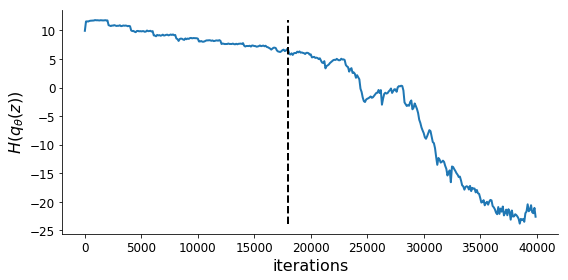

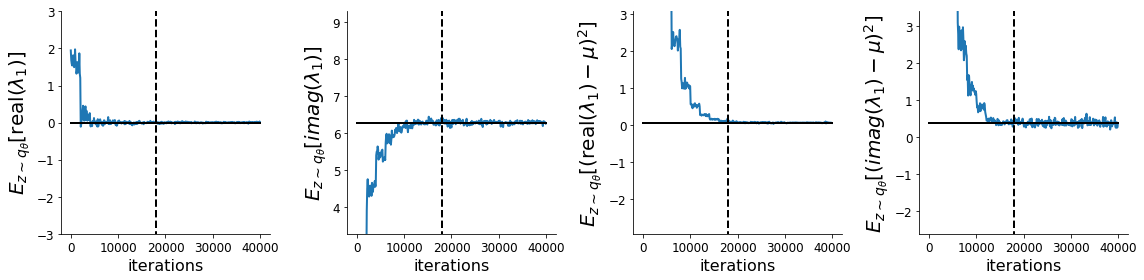

In [3]:
frac_samps = 0.1

sysname = "Linear2D"
param_dict = {'omega':omega,
              'd_std':d_std,
              'omega_std':omega_std}
system = get_system_from_template(sysname, param_dict)


arch_params = {
               'D':system.D,
               'repeats':repeats,
               'nlayers':nlayers,
               'sigma_init':sigma_init,
              }
param_dict.update(arch_params)
arch_dict = get_arch_from_template(system, param_dict)

dir_str = '2DLDS/'

model_dirs = [];
legendstrs = [];
for rs in range(start_rs, start_rs+num_rs):
    savedir = get_savedir(system, arch_dict, c_init, rs, dir_str)
    model_dirs.append(savedir)
    legendstr = 'rs=%d' % rs;
    legendstrs.append(legendstr);
    
figs, ME_its = plot_opt(model_dirs, frac_samps=frac_samps, T_x_labels=system.T_x_labels);

In [4]:
print(ME_its)

[array(9)]


ticks None
0
dist (1000, 4)
not saving figure


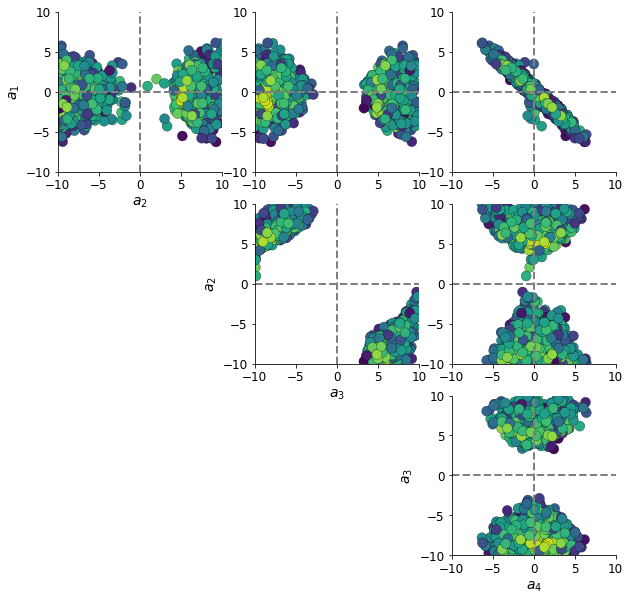

In [5]:
#ME_its = num_rs*[4]
Zs, log_q_zs, axs = dsn_pairplots(model_dirs, 'Zs', system, ME_its, 
                                  xlims=[-10,10], ylims=[-10,10])

In [6]:
from dsn.util.dsn_util import load_DSNs
sessions, tf_vars, feed_dicts = load_DSNs(model_dirs, ME_its)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/2DLDS//Linear2D_A_oscillation_mu=0.00E+00_6.28E+00_6.25E-02_3.95E-01_flow=1R_4M_2L_15U_M_A_iso_std=3.0_sigma=3.00_c=-3_rs=6/model-9
Loaded DGM in 1.31 seconds
here 1


In [7]:
from tf_util.stat_util import approx_equal
EPS = 1e-16
def marginalize_mesh(c,ax1,ax2):
    D = len(c.shape)
    for i in range(D-1,-1, -1):
        if (not (i==ax1 or i==ax2)):
            c = np.mean(c, i)
    return c

n = 20
# D = 3
c = np.random.uniform(0.0, 100.0, (n,n,n))
c_ans = np.mean(c, 2)
assert(approx_equal(c_ans, marginalize_mesh(c, 0, 1), EPS))
assert(approx_equal(c_ans, marginalize_mesh(c, 1, 0), EPS))

c_ans = np.mean(c, 1)
assert(approx_equal(c_ans, marginalize_mesh(c, 0, 2), EPS))
assert(approx_equal(c_ans, marginalize_mesh(c, 2, 0), EPS))

c_ans = np.mean(c, 0)
assert(approx_equal(c_ans, marginalize_mesh(c, 1, 2), EPS))
assert(approx_equal(c_ans, marginalize_mesh(c, 2, 1), EPS))

# D = 4
c = np.random.uniform(0.0, 100.0, (n,n,n,n))
c_ans = np.mean(np.mean(c, 3), 2)
assert(approx_equal(c_ans, marginalize_mesh(c, 0, 1), EPS))
assert(approx_equal(c_ans, marginalize_mesh(c, 1, 0), EPS))

c_ans = np.mean(np.mean(c, 3), 1)
assert(approx_equal(c_ans, marginalize_mesh(c, 0, 2), EPS))
assert(approx_equal(c_ans, marginalize_mesh(c, 2, 0), EPS))

c_ans = np.mean(np.mean(c, 3), 0)
assert(approx_equal(c_ans, marginalize_mesh(c, 1, 2), EPS))
assert(approx_equal(c_ans, marginalize_mesh(c, 2, 1), EPS))

c_ans = np.mean(np.mean(c, 2), 1)
assert(approx_equal(c_ans, marginalize_mesh(c, 0, 3), EPS))
assert(approx_equal(c_ans, marginalize_mesh(c, 3, 0), EPS))

c_ans = np.mean(np.mean(c, 2), 0)
assert(approx_equal(c_ans, marginalize_mesh(c, 1, 3), EPS))
assert(approx_equal(c_ans, marginalize_mesh(c, 3, 1), EPS))

c_ans = np.mean(np.mean(c, 1), 0)
assert(approx_equal(c_ans, marginalize_mesh(c, 2, 3), EPS))
assert(approx_equal(c_ans, marginalize_mesh(c, 3, 2), EPS))

-94.18469483686236
-172.4390828672158
-223.81518151385188
-35.86179797538315
-80.87008770590138
-159.3674201685719


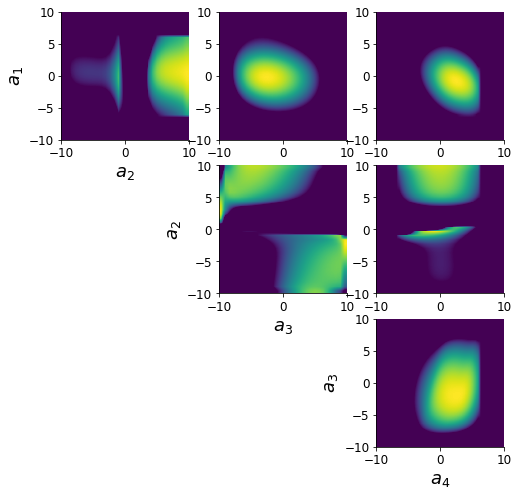

In [8]:
from dsn.util.plot_util import imshow_pairplot
lb, ub = system.density_network_bounds
alpha_val = 1.0
buf = 1e-2
ext_fac = 0.0
K = 30
M = K**system.D

M_samp = 1000

def get_marg_vmins(Z_samp, W, Z_input, Z_INV, log_q_Z, sess, feed_dict, K=20, q=10):
    M_samp = Z_samp.shape[1]
    D = Z_samp.shape[2]
    min_samp = np.min(Z_samp[0], 0)
    max_samp = np.max(Z_samp[0], 0)
    
    vmins = np.zeros((D,D))
    for i in range(D-1):
        for j in range(i+1,D):
            meshvals = []
            for ii in range(D):
                if (not ii==i):
                    if (ii==j):
                        meshvals.append(Z_samp[0,:,j])
                    else:
                        meshvals.append(np.linspace(min_samp[ii], max_samp[ii], K))
            Z_grids = np.meshgrid(*meshvals, indexing='ij')
        
            M = int(np.prod(Z_grids[0].shape))
            _Z_grid = np.zeros((1,M,D))
            _Z_grid[0,:,i] = np.reshape(np.tile(Z_samp[:,:,i], (K**(D-2),1)).T, (K**(D-2)*M_samp,))
            _i = 0
            for d in range(D):
                if (not d == i):
                    _Z_grid[0,:,d] = np.reshape(Z_grids[_i], (M,))
                    _i += 1
                    
            _W = np.zeros((1,M,system.D))
            feed_dict.update({Z_input:_Z_grid, W:_W})
            _Z_INV = sess.run(Z_INV, feed_dict)

            feed_dict.update({W:_Z_INV})
            _log_q_z = sess.run(log_q_Z, feed_dict)
            vmins[i,j] = np.percentile(_log_q_z, q)
    return vmins
                

for i in range(1):
    sess = sessions[i]
    tf_var = tf_vars[i]
    feed_dict = feed_dicts[i]
    W, Z, Z_input, Z_INV, log_q_Z, bn_mus, bn_sigmas, bn_means, bn_vars  = tf_var
    
    _W = np.random.normal(0.0, 1.0, (1,M_samp,system.D))
    _Z_input_dummy = np.zeros((1,1,system.D))
    feed_dict.update({W:_W, Z_input:_Z_input_dummy})
    _Z_samp, _log_q_Z = sess.run([Z, log_q_Z], feed_dict)
    
    #vmins = get_marg_vmins(_Z_samp, W, Z_input, Z_INV, log_q_Z, sess, feed_dict)
    min_samp = np.min(_Z_samp[0], 0)
    max_samp = np.max(_Z_samp[0], 0)

    interval_samp = max_samp - min_samp
    a_grid = np.zeros((system.D))
    b_grid = np.zeros((system.D))
    for j in range(system.D):
        a_grid[j] = max(min_samp[j] - ext_fac*interval_samp[j], lb[j]+buf)
        b_grid[j] = min(max_samp[j] + ext_fac*interval_samp[j], ub[j]-buf)
        
    Z_grids = np.meshgrid(np.linspace(a_grid[0], b_grid[0], K),
                          np.linspace(a_grid[1], b_grid[1], K),
                          np.linspace(a_grid[2], b_grid[2], K),
                          np.linspace(a_grid[3], b_grid[3], K), indexing='ij')
    
    _Z_grid = np.zeros((1,M,system.D))
    for i in range(system.D):
        _Z_grid[0,:,i] = np.reshape(Z_grids[i], (M,))
    
    log_q_z_mesh = get_log_q_z_mesh(_Z_grid, W, Z_input, Z_INV, log_q_Z, sess, feed_dict, K)
    
    fig, axs = imshow_pairplot(log_q_z_mesh, range(4), system.z_labels,
                               lb=lb, ub=ub, a=a_grid, b=b_grid, fontsize=18,
                               figsize=(8,8), alpha=alpha_val,
                               fig=None, axs=None, q=50)
    plt.show()

ticks None
0
dist (1000, 4)
not saving figure


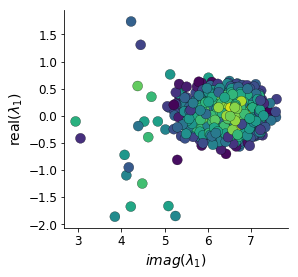

In [9]:
T_xs = dsn_pairplots(model_dirs, 'T_xs', system, ME_its, D=2, figsize=(4,4))

In [10]:
Z = Zs[0]
log_q_z = log_q_zs[0]
a1 = Z[:,0]
a2 = Z[:,1]
a3 = Z[:,2]
a4 = Z[:,3]

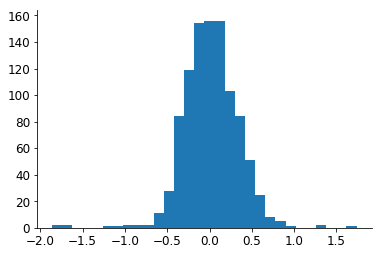

In [11]:
plt.figure()
plt.hist((a1+a4)/2, 30)
plt.show()

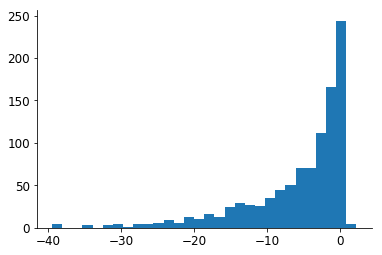

In [12]:
plt.figure()
plt.hist(a1*a4, 30)
plt.show()

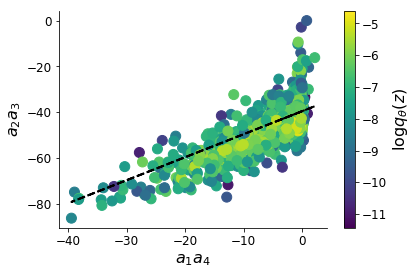

In [13]:
x = a1*a4
y = x - (2.0*np.pi*omega)**2

plt.figure()
plt.scatter(a1*a4, a2*a3, c=log_q_z)
plt.plot(x, y, 'k--')
plt.xlabel(r'$a_1 a_4$')
plt.ylabel(r'$a_2 a_3$')
clb = plt.colorbar()
clb.set_label(r'$\log q_\theta(z)$', rotation=90)
plt.show()

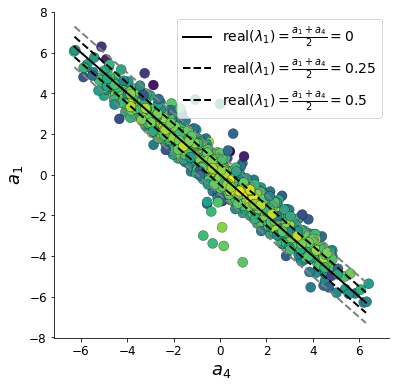

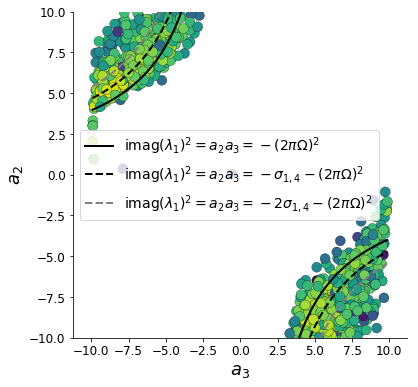

In [18]:
Z = Zs[0]
log_q_z = log_q_zs[0]

fontsize = 18
xlabels = [r'$a_4$', r'$a_3$']
ylabels = [r'$a_1$', r'$a_2$']
x_inds = [3, 2]
y_inds = [0, 1]

num_plts = len(x_inds)
fig, ax = plt.subplots(1,1,figsize=(6,6))

n = 100

#std1 = np.std((a1 + a4)/2.0)

realstd = 0.25
# plot std lines in real(lambda)
# mean
x1 = np.linspace(np.min(Z[:,0]), np.max(Z[:,0]), n)
ax.plot(x1, -x1, 'k')
ax.plot(x1, -(2*realstd)-x1, 'k--')
ax.plot(x1, +(2*realstd)-x1, 'k--')
ax.plot(x1, -(4*realstd)-x1, '--', c='gray')
ax.plot(x1, +(4*realstd)-x1, '--', c='gray')
"""ax.plot(x1, -2*(std1)-x1, 'k--')
ax.plot(x1, -2*(2*std1)-x1, '--', c='gray')
ax.plot(x1, +2*(std1)-x1, 'k--')
ax.plot(x1, +2*(2*std1)-x1, '--', c='gray')"""

legendstrs = [r'real$(\lambda_1) = \frac{a_1 + a_4}{2} = 0$',
              r'real$(\lambda_1) = \frac{a_1 + a_4}{2} = 0.25$',
              r'real$(\lambda_1) = \frac{a_1 + a_4}{2} = 0.5$']

ax.legend(legendstrs)
# plot the data-points
i = 0
x_ind = x_inds[i]
y_ind = y_inds[i]

ax.scatter(Z[:,x_ind], Z[:,y_ind], c=log_q_z, 
               edgecolors="k", linewidths=0.25)
ax.set_xlabel(xlabels[i], fontsize=fontsize)
ax.set_ylabel(ylabels[i], fontsize=fontsize)


std2 = np.std(a1*a4)
fig, ax = plt.subplots(1,1,figsize=(6,6))

x31 = np.linspace(np.min(Z[:,2]), -0.01, n//2)
x32 = np.linspace(0.01, np.max(Z[:,2]), n//2)

ax.plot(x31, -((2*np.pi)**2)/x31, 'k')
ax.plot(x31, (-std2 - ((2*np.pi)**2))/x31, 'k--')
ax.plot(x31, (-2.0*std2 - ((2*np.pi)**2))/x31, '--', c='gray')

ax.plot(x32, -((2*np.pi)**2)/x32, 'k')
ax.plot(x32, (-std2 - ((2*np.pi)**2))/x32, 'k--')
ax.plot(x32, (-2.0*std2 - ((2*np.pi)**2))/x32, '--', c='gray')


ax.set_ylim([-10, 10])

i = 1
x_ind = x_inds[i]
y_ind = y_inds[i]

ax.scatter(Z[:,x_ind], Z[:,y_ind], c=log_q_z, 
               edgecolors="k", linewidths=0.25)
ax.set_xlabel(xlabels[i], fontsize=fontsize)
ax.set_ylabel(ylabels[i], fontsize=fontsize)

legendstrs = [r'imag$(\lambda_1)^2 = a_2 a_3 = - (2 \pi \Omega)^2$',
              r'imag$(\lambda_1)^2 = a_2 a_3 = - \sigma_{1,4} - (2 \pi \Omega)^2$',
              r'imag$(\lambda_1)^2 = a_2 a_3 = - 2\sigma_{1,4} - (2 \pi \Omega)^2$']
ax.legend(legendstrs)



plt.show()

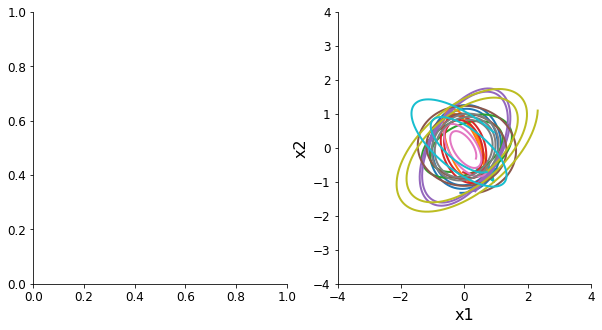

In [21]:
def simulate_2DLDS(x0, A, tau, dt, T):
    def f(x):
        return np.dot(A, x)
    
    x = np.zeros((2, T+1))
    x[:,0] = x0
    x_i = x0
    for i in range(T):
        x_i = x_i + (dt/tau)*f(x_i)
        x[:,i+1] = x_i
    return x

x0 = np.array([np.sqrt(2)/2, -np.sqrt(2)/2])
tau = 1.0
dt = 1e-3
T = 2000

fig, axs = plt.subplots(1,2,figsize=(10, 5))
plt.plot([x0[0]], [x0[1]], 'c*', markersize=25)
for i in range(10):
    A = np.reshape(Z[i,:], (2,2))
    x = simulate_2DLDS(x0, A, tau, dt, T)
    plt.plot(x[0], x[1])
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()


In [16]:
from dsn.util.dsn_util import load_DSNs
sessions, tf_vars, feed_dicts = load_DSNs(model_dirs, ME_its)

INFO:tensorflow:Restoring parameters from models/2DLDS//Linear2D_A_oscillation_mu=0.00E+00_6.28E+00_6.25E-02_3.95E-01_flow=1R_4M_2L_15U_M_A_sigma=3.00_c=-3_rs=6/model-9
Loaded DGM in 1.49 seconds


In [25]:
M = 1000
plot_inds = [0,1,2,3,4]
xlabels = [r'$a_4$', r'$a_3$']
ylabels = [r'$a_1$', r'$a_2$']
for k in range(len(model_dirs)):
    sess = sessions[k]
    W, Z, Z_input, Z_INV, log_q_Z, batch_norm_mus, batch_norm_sigmas, batch_norm_means, batch_norm_vars = tf_vars[k]
    feed_dict = feed_dicts[k]
    print('W', W)
    print('Z', Z)
    print('Z_input', Z_input)
    print('Z_INV', Z_INV)
    print('log_q_Z', log_q_Z)
    
    _Z_input_dummy = np.zeros((1,1,4,))
    _W = np.random.normal(0.0, 1.0, ((1,1,4,)))
    feed_dict.update({W:_W, Z_input:_Z_input_dummy})
    _Z = sess.run(Z, feed_dict)
    print('W', _W)
    print('Z', _Z)
    
    feed_dict.update({W:np.zeros((1,1,4)), Z_input:_Z})
    _Z_INV = sess.run(Z_INV, feed_dict)
    print('Z', _Z)
    print('Z_INV', _Z_INV)
    
    continue
    T_xs = system.compute_suff_stats(Z)
    feed_dict = feed_dicts[k]
    
    print('calc hess')
    H = dgm_hessian(log_q_Z, W, Z, Z_INV)
    print('done')
    
    #Get large sample from model to estimate mode
    _W = np.random.normal(0.0, 1.0, (1,M,system.D))
    feed_dict.update({W:_W})
    _Z, _T_xs, _log_q_z = sess.run([Z, T_xs, log_q_Z], feed_dict)
    dist_from_center = np.linalg.norm(_T_xs[0,:,[True,False,False,True]], axis=0)
    
    for plot_ind in plot_inds:
        z_max_inds = np.argsort(dist_from_center)
        z_max_ind = z_max_inds[plot_ind]
        z_max = _Z[0,z_max_ind]
        w_max = np.expand_dims(_W[:,z_max_ind,:], 1)
        feed_dict.update({W:w_max})
        print(plot_ind, 'run hess')
        _H = sess.run(H, feed_dict)
        print('done')

        d, v = np.linalg.eig(_H)
        print('d', d)
        print(_Z.shape)

        I_inds = np.argsort(-np.abs(d))
        scale = 1.0

        vs = []
        ds = []
        for i in range(system.D):
            vs.append(v[:,I_inds[i]])
            ds.append(d[I_inds[i]])

        scale = 0.1

        fontsize = 14


        x_inds = [3, 2]
        y_inds = [0, 1]

        num_plts = len(x_inds)
        fig, axs = plt.subplots(1,num_plts,figsize=(8,4))
        scale_vs = [10.0, 20.0]
        for i in range(num_plts):
            scale_v = scale_vs[i]
            x_ind = x_inds[i]
            y_ind = y_inds[i]

            axs[i].scatter(_Z[0,:,x_ind], _Z[0,:,y_ind], c=_log_q_z[0,:], 
                           edgecolors="k", linewidths=0.25)
            axs[i].plot(_Z[0,z_max_ind,x_ind], _Z[0,z_max_ind,y_ind], 'k*', markersize=15)

            # show greatest eig
            vx = [_Z[0,z_max_ind,x_ind] - scale_v*vs[0][x_ind], 
                  _Z[0,z_max_ind,x_ind] + scale_v*vs[0][x_ind]]
            vy = [_Z[0,z_max_ind,y_ind] - scale_v*vs[0][y_ind], 
                  _Z[0,z_max_ind,y_ind] + scale_v*vs[0][y_ind]]
            axs[i].plot(vx, vy, 'k--')

            vx = [_Z[0,z_max_ind,x_ind] - scale_v*vs[-1][x_ind], 
                  _Z[0,z_max_ind,x_ind] + scale_v*vs[-1][x_ind]]
            vy = [_Z[0,z_max_ind,y_ind] - scale_v*vs[-1][y_ind], 
                  _Z[0,z_max_ind,y_ind] + scale_v*vs[-1][y_ind]]
            axs[i].plot(vx, vy, 'k-')

            axs[i].set_xlabel(xlabels[i], fontsize=fontsize)
            axs[i].set_ylabel(ylabels[i], fontsize=fontsize)

            axs[i].spines['top'].set_visible(False)
            axs[i].spines['right'].set_visible(False)

        plt.show()

W Tensor("W:0", shape=(1, ?, 4), dtype=float64)
Z Tensor("SupportMapping/add:0", shape=(1, ?, 4), dtype=float64)
Z_input Tensor("Placeholder:0", shape=(1, ?, 4), dtype=float64)
Z_INV Tensor("add_131:0", shape=(1, ?, 4), dtype=float64)
log_q_Z Tensor("Entropy/sub_1:0", shape=(1, ?), dtype=float64)
W [[[-0.3596175   0.89511184 -0.05919958 -1.67949793]]]
Z [[[ 0.87448704  7.12056961 -5.68190231 -1.75625081]]]
Z [[[ 0.87448704  7.12056961 -5.68190231 -1.75625081]]]
Z_INV [[[-0.3596175   0.89511184 -0.05919958 -1.67949793]]]


In [65]:
load_its = np.arange(0, 80, 5)
num_its = load_its.shape[0]
one_model = num_its*[model_dirs[0]]

sessions, tf_vars, feed_dicts = load_DSNs(one_model, load_its)

INFO:tensorflow:Restoring parameters from models/LDS_test//Linear2D_A_oscillation_mu=0.00E+00_6.28E+00_1.00E+00_1.00E+00_flow=1R_4M_2L_10U_M_A_sigma=1.00_c=-1_rs=3/model-0
Loaded DGM in 15.20 seconds
INFO:tensorflow:Restoring parameters from models/LDS_test//Linear2D_A_oscillation_mu=0.00E+00_6.28E+00_1.00E+00_1.00E+00_flow=1R_4M_2L_10U_M_A_sigma=1.00_c=-1_rs=3/model-5
INFO:tensorflow:Restoring parameters from models/LDS_test//Linear2D_A_oscillation_mu=0.00E+00_6.28E+00_1.00E+00_1.00E+00_flow=1R_4M_2L_10U_M_A_sigma=1.00_c=-1_rs=3/model-10
INFO:tensorflow:Restoring parameters from models/LDS_test//Linear2D_A_oscillation_mu=0.00E+00_6.28E+00_1.00E+00_1.00E+00_flow=1R_4M_2L_10U_M_A_sigma=1.00_c=-1_rs=3/model-15
INFO:tensorflow:Restoring parameters from models/LDS_test//Linear2D_A_oscillation_mu=0.00E+00_6.28E+00_1.00E+00_1.00E+00_flow=1R_4M_2L_10U_M_A_sigma=1.00_c=-1_rs=3/model-20
INFO:tensorflow:Restoring parameters from models/LDS_test//Linear2D_A_oscillation_mu=0.00E+00_6.28E+00_1.00E+

In [66]:
num_batch_norms = 4
post_bn_means = np.zeros((num_batch_norms, system.D, num_its))
post_bn_stds = np.zeros((num_batch_norms, system.D, num_its))

M = 10000
_W = np.random.normal(0.0, 1.0, (1,M,4))
for i in range(num_its):
    print('i', i)
    sess = sessions[i]
    W, Z, Z_INV, log_q_Z, batch_norm_mus, batch_norm_sigmas, batch_norm_means, batch_norm_vars = tf_vars[i]
    feed_dict = feed_dicts[i]
    
    feed_dict.update({W:_W})
    
    _batch_norm_means, _batch_norm_sigmas, _batch_norm_means, _batch_norm_sigmas = sess.run(
                     [batch_norm_mus, batch_norm_sigmas, batch_norm_means, batch_norm_vars], 
                     feed_dict
                    )
    
    for j in range(num_batch_norms):
        post_bn_means[j,:,i] = (_batch_norm_means[j] - _batch_norm_mus[j])/_batch_norm_sigmas[j]
        post_bn_stds[j,:,i] = np.sqrt(_batch_norm_vars[j]) / _batch_norm_sigmas[j]
    

i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
i 10
i 11
i 12
i 13
i 14
i 15


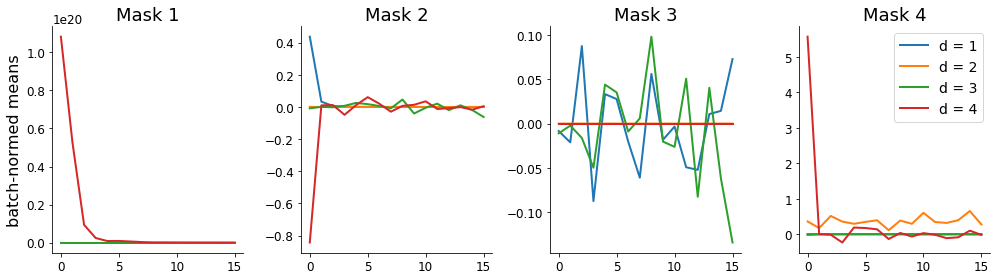

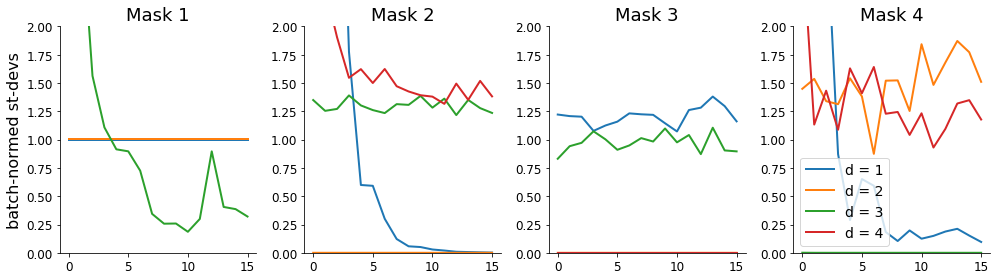

In [68]:
fig, axs = plt.subplots(1,4, figsize=(14,4))
for i in range(num_batch_norms):
    axs[i].plot(post_bn_means[i,:,:].T)
    axs[i].set_title('Mask %d' % (i+1))
axs[-1].legend(['d = %d' % i for i in range(1, 5)])
axs[0].set_ylabel('batch-normed means')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,4, figsize=(14,4))
for i in range(num_batch_norms):
    axs[i].plot(post_bn_stds[i,:,:].T)
    axs[i].set_title('Mask %d' % (i+1))
    axs[i].set_ylim([0, 2])
axs[-1].legend(['d = %d' % i for i in range(1, 5)])
axs[0].set_ylabel('batch-normed st-devs')
plt.tight_layout()
plt.show()